In [1]:
import numpy as np
import matplotlib.pylab as plt
from tqdm import trange

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
import torch
import torch.nn as nn
from torch.optim import Adam

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

---

### DATA

In [4]:
def fetch(url):
    import os, requests, gzip, hashlib, numpy
    filepath = os.path.join("/tmp", hashlib.md5(url.encode('utf-8')).hexdigest())
    if os.path.isfile(filepath):
        with open(filepath, 'rb') as f:
            data = f.read()
    else:
        with open(filepath, 'wb') as f:
            data = requests.get(url).content
            f.write(data)
    return numpy.frombuffer(gzip.decompress(data), dtype=np.uint8).copy()

In [5]:
ds = fetch('http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz')[0x10:].reshape(-1, 28, 28) / 255.0
# ds = (ds * 2) - 1 # Normalise between -1 and 1

print('Min:', np.min(ds), 'Max:', np.max(ds))

Min: 0.0 Max: 1.0


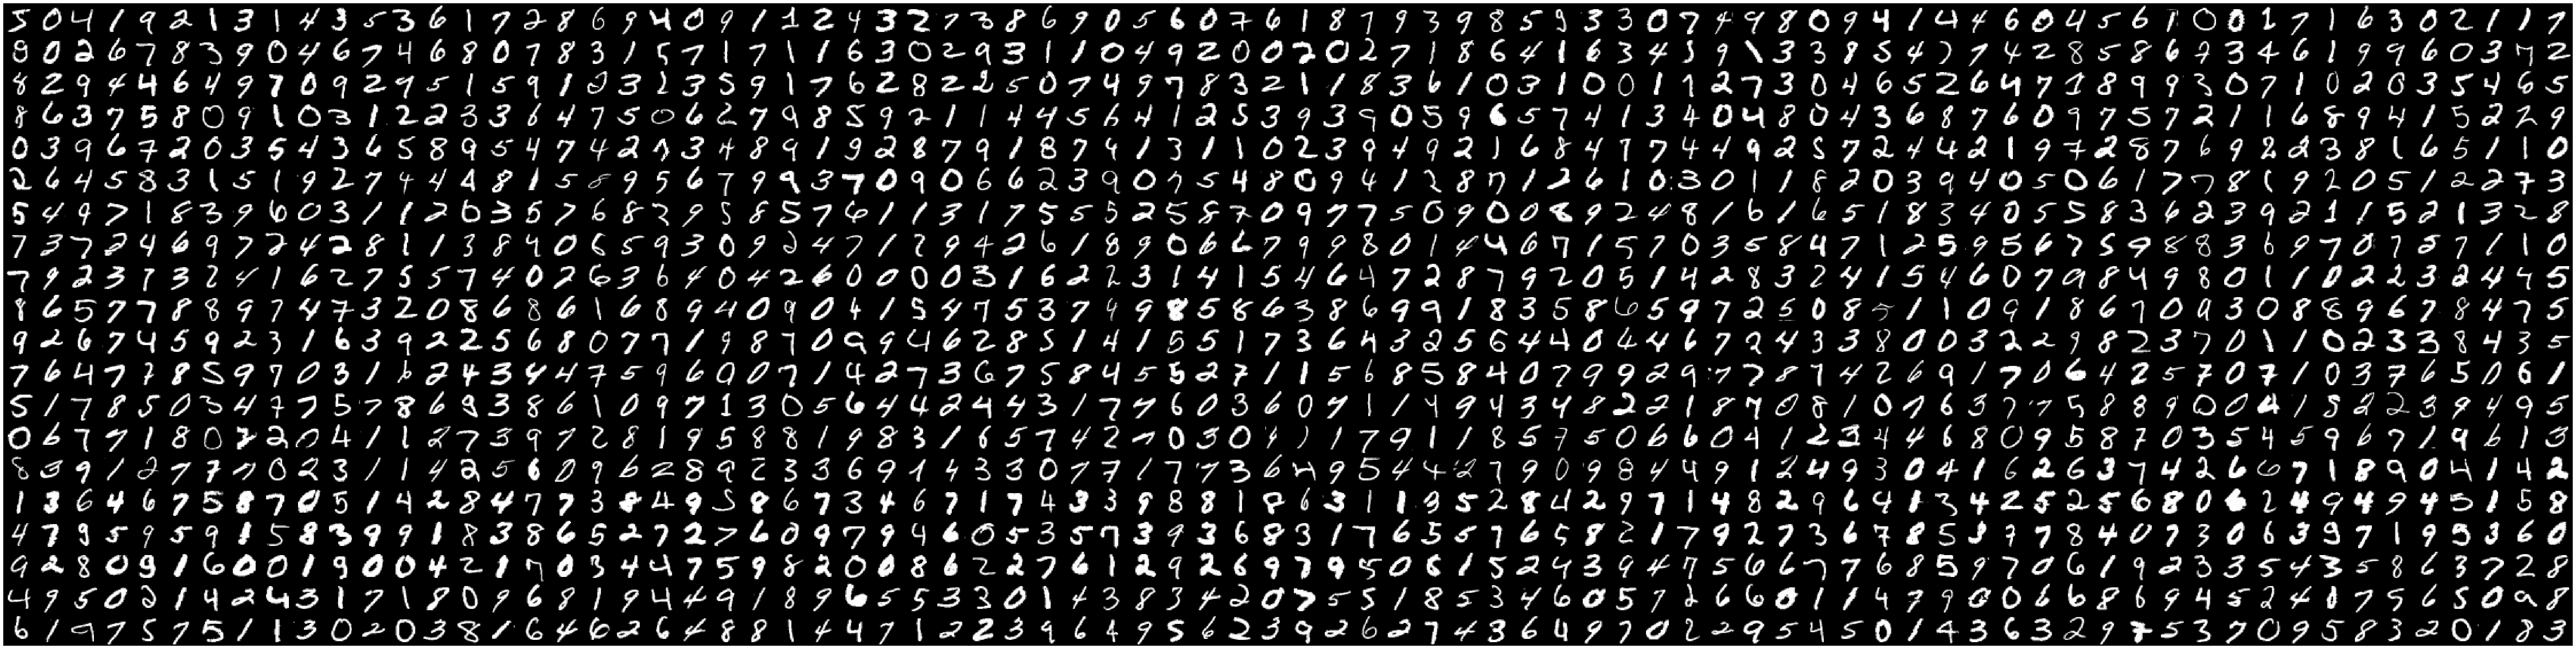

In [6]:
result = np.concatenate([np.concatenate(ds[i*80:(i+1)*80], axis=1) for i in range(20)])

plt.figure(figsize=(80,20))
plt.imshow(result, 'gray')
plt.axis('off')
plt.tight_layout()

---

### TRAINING

In [7]:
class Encoder(nn.Module):
    
    def __init__(self, input_dim=784, hidden_dim=512, latent_dim=256):
        super(Encoder, self).__init__()

        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.mean = nn.Linear(hidden_dim, latent_dim)
        self.var = nn.Linear (hidden_dim, latent_dim)
        self.LeakyReLU = nn.LeakyReLU(0.2)
        self.training = True
        
    def forward(self, x):
        x = self.LeakyReLU(self.linear1(x))
        x = self.LeakyReLU(self.linear2(x))

        mean = self.mean(x)
        log_var = self.var(x)                     
        return mean, log_var

In [8]:
class Decoder(nn.Module):
    
    def __init__(self, output_dim=784, hidden_dim=512, latent_dim=256):
        super(Decoder, self).__init__()

        self.linear2 = nn.Linear(latent_dim, hidden_dim)
        self.linear1 = nn.Linear(hidden_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, output_dim)
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        x = self.LeakyReLU(self.linear2(x))
        x = self.LeakyReLU(self.linear1(x))
        
        x_hat = torch.sigmoid(self.output(x))
        return x_hat

In [9]:
class VAE(nn.Module):

    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=200, device=device):
        super(VAE, self).__init__()

        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, latent_dim),
            nn.LeakyReLU(0.2)
            )
        
        # latent mean and variance 
        self.mean_layer = nn.Linear(latent_dim, 2)
        self.logvar_layer = nn.Linear(latent_dim, 2)
        
        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(2, latent_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
            )
     
    def encode(self, x):
        x = self.encoder(x)
        mean, logvar = self.mean_layer(x), self.logvar_layer(x)
        return mean, logvar

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(device)      
        z = mean + var*epsilon
        return z

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterization(mean, logvar)
        x_hat = self.decode(z)
        return x_hat, mean, log_var
        
    def forward(self, x):
        mean, log_var = self.encode(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) 
        x_hat = self.decode(z)  
        return x_hat, mean, log_var

In [10]:
model = VAE().to(device)
parameters = model.parameters()
print("Nparams:", sum(p.nelement() for p in parameters))
print(model.eval())

Nparams: 790388
VAE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=400, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=400, out_features=200, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
  )
  (mean_layer): Linear(in_features=200, out_features=2, bias=True)
  (logvar_layer): Linear(in_features=200, out_features=2, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=200, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=200, out_features=400, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=400, out_features=784, bias=True)
    (5): Sigmoid()
  )
)


In [11]:
def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

In [12]:
bs = 128
simlen = 10000
lr = 1e-3
optim = Adam(model.parameters(), lr=lr)

In [13]:
for i in (t := trange(simlen)):
    overall_loss = 0

    idx = np.random.randint(0, ds.shape[0], size=bs)
    x = torch.tensor(ds[idx].reshape((-1,28*28))).float()

    optim.zero_grad()

    x_hat, mean, log_var = model(x)
    loss = loss_function(x, x_hat, mean, log_var)

    overall_loss += loss.item()

    loss.backward()
    optim.step()

    t.set_description("Epoch %:.0f Loss %.2f" % (i, overall_loss))

Epoch 9999.00 Loss 18919.01: 100%|██████████| 10000/10000 [02:42<00:00, 61.40it/s]


In [14]:
def generate_digit(mean, var):
    z_sample = torch.tensor([[mean, var]], dtype=torch.float).to(device)
    x_decoded = model.decode(z_sample)
    digit = x_decoded.detach().cpu().reshape(28, 28) # reshape vector to 2d array
    plt.title(f'[{mean},{var}]')
    plt.imshow(digit, cmap='gray')
    plt.axis('off')

(None, None)

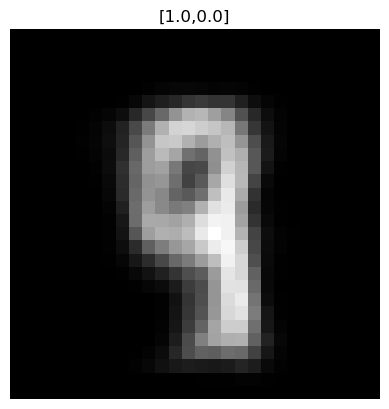

In [15]:
generate_digit(0.0, 1.0), generate_digit(1.0, 0.0)

In [16]:
def plot_latent_space(model, scale=5.0, n=25, digit_size=28, figsize=15):
    # display a n*n 2D manifold of digits
    figure = np.zeros((digit_size * n, digit_size * n))

    # construct a grid 
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.tensor([[xi, yi]], dtype=torch.float).to(device)
            x_decoded = model.decode(z_sample)
            digit = x_decoded[0].detach().cpu().reshape(digit_size, digit_size)
            figure[i * digit_size : (i + 1) * digit_size, j * digit_size : (j + 1) * digit_size,] = digit

    plt.figure(figsize=(figsize, figsize))
    plt.title('VAE Latent Space Visualization')
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("mean, z [0]")
    plt.ylabel("var, z [1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

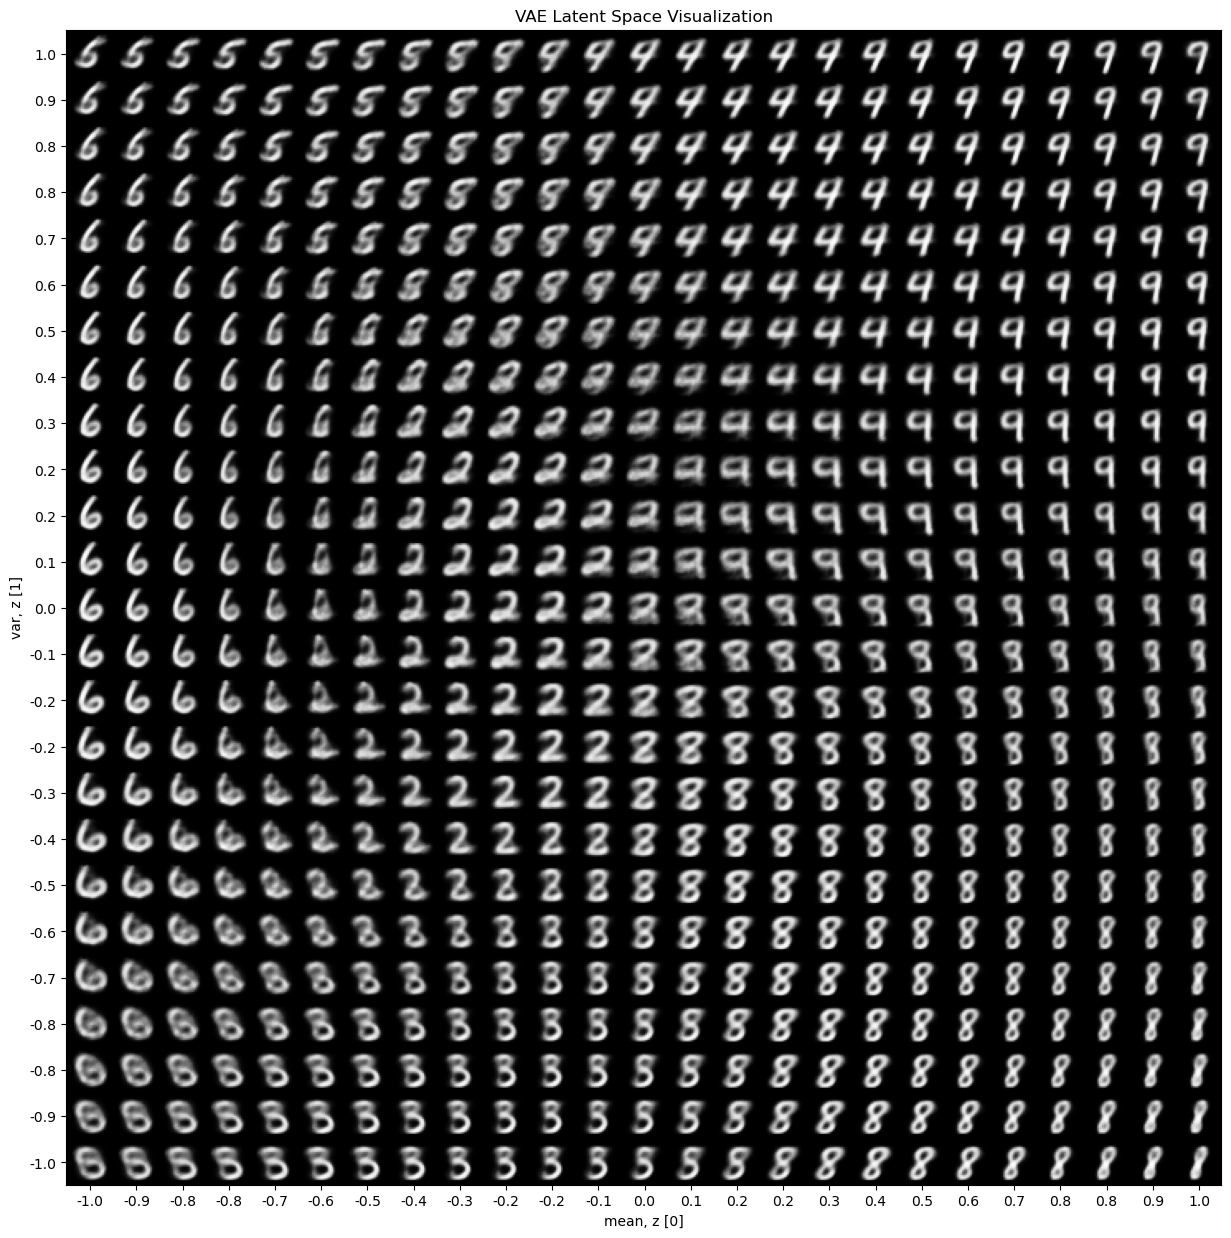

In [17]:
plot_latent_space(model, scale=1.0)